# Titanic

In [437]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import catboost
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from optuna import visualization 
from optuna.integration import OptunaSearchCV 
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
from catboost import CatBoostClassifier, Pool, cv

import random

# Фиксация всех seed
np.random.seed(42)
random.seed(42)

### Загрузка и ознакомление

In [438]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [439]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [440]:
train.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [441]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [442]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [443]:
train['Cabin'] = train['Cabin'].fillna('Unknown')
train['Age'] = train.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))
train['Embarked'] = train['Embarked'].fillna('Unknown')


In [444]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [445]:
train.duplicated().sum()

np.int64(0)

In [446]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [447]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [448]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [449]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [450]:
test['Cabin'] = test['Cabin'].fillna('Unknown')
test['Age'] = test.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [451]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [452]:
test.duplicated().sum()

np.int64(0)

### EDA

Survived
0    549
1    342
Name: count, dtype: int64

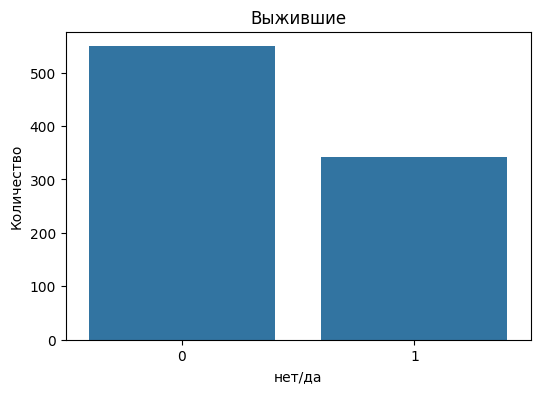

In [453]:
display(train['Survived'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Survived')
plt.title('Выжившие')
plt.xlabel('нет/да')
plt.ylabel('Количество')
plt.show()


Дисбаланс в целевой переменной


Pclass
3    491
1    216
2    184
Name: count, dtype: int64

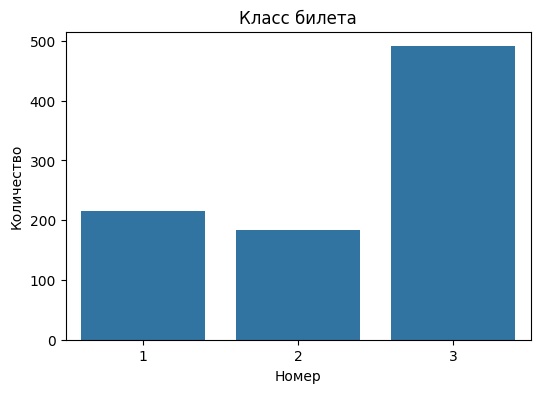

In [454]:
display(train['Pclass'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Pclass')
plt.title('Класс билета')
plt.xlabel('Номер')
plt.ylabel('Количество')
plt.show()

Sex
male      577
female    314
Name: count, dtype: int64

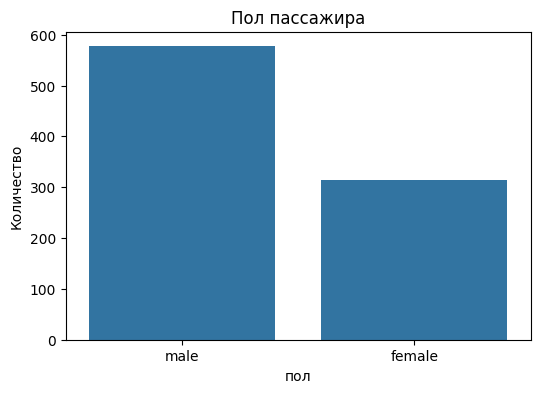

In [455]:
display(train['Sex'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Sex')
plt.title('Пол пассажира')
plt.xlabel('пол')
plt.ylabel('Количество')
plt.show()

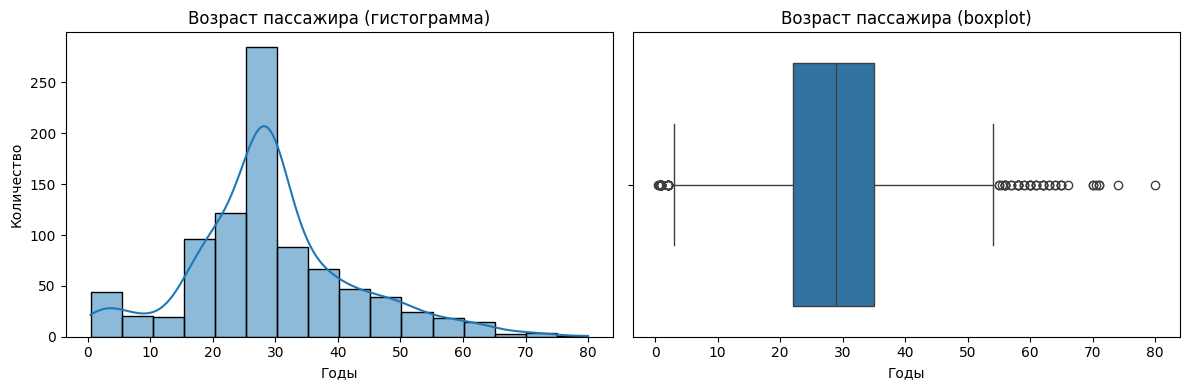

In [456]:
# Создаем один figure с двумя графиками (в ряд)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # Общий размер всего изображения

# Гистограмма + KDE
sns.histplot(train, x='Age', bins=16, kde=True, ax=ax[0])
ax[0].set_title('Возраст пассажира (гистограмма)')
ax[0].set_xlabel('Годы')
ax[0].set_ylabel('Количество')

# Boxplot
sns.boxplot(train, x='Age', ax=ax[1])
ax[1].set_title('Возраст пассажира (boxplot)')
ax[1].set_xlabel('Годы')

# Чтобы графики не накладывались друг на друга
plt.tight_layout()
plt.show()

Средний возраст около 30 лет

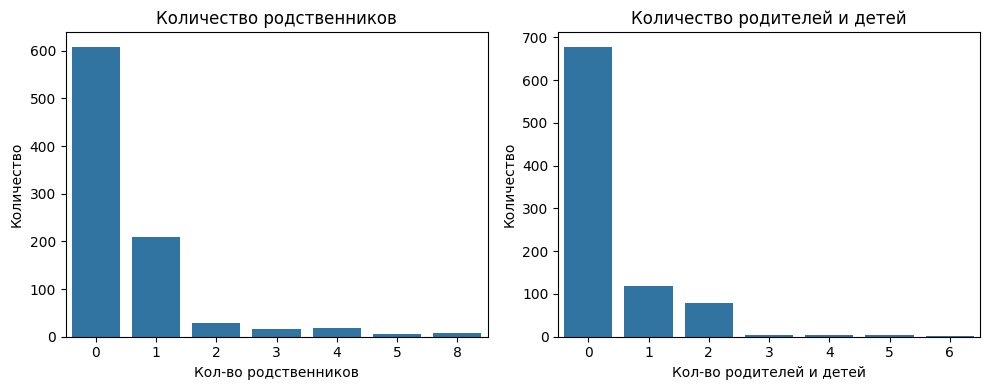

In [457]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

sns.countplot(train, x='SibSp', ax=ax[0])
ax[0].set_title('Количество родственников')
ax[0].set_xlabel('Кол-во родственников')
ax[0].set_ylabel('Количество')

sns.countplot(train, x='Parch', ax=ax[1])
ax[1].set_title('Количество родителей и детей')
ax[1].set_xlabel('Кол-во родителей и детей')
ax[1].set_ylabel('Количество')

plt.tight_layout()
plt.show()

У большинства пассажиров нет родственников.

Большинство пассажиров без семей.

Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

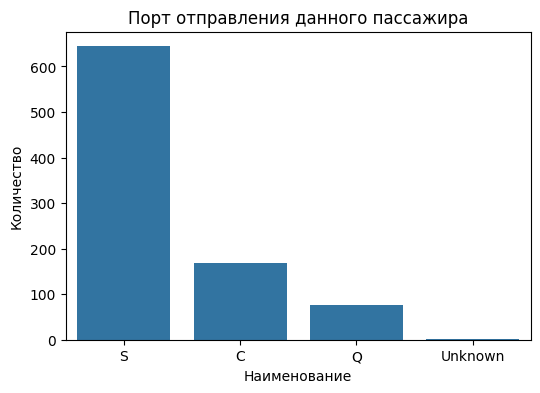

In [458]:
display(train['Embarked'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Embarked')
plt.title('Порт отправления данного пассажира')
plt.xlabel('Наименование')
plt.ylabel('Количество')
plt.show()

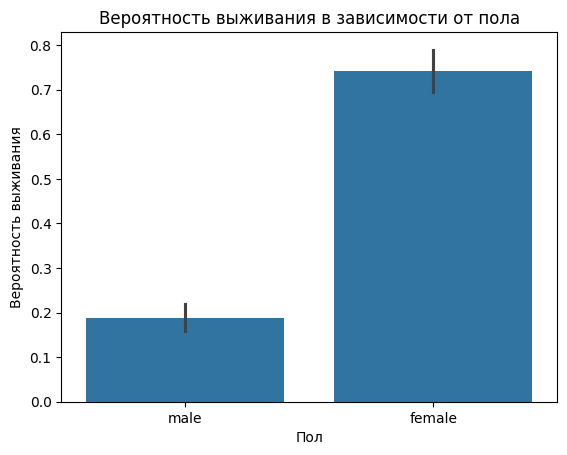

In [459]:
train.groupby('Sex')['Survived'].mean()
sns.barplot(train, x='Sex', y='Survived')
plt.title('Вероятность выживания в зависимости от пола')
plt.xlabel('Пол')
plt.ylabel('Вероятность выживания')
plt.show()

Большинство выживших женщины

### Feature Engineering

In [460]:
# Общий размер семьи (включая самого пассажира)
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# Извлечение титула (Mr, Mrs, Miss и т.д.)
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)



# Группировка редких титулов
for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Первая буква номера каюты (если есть)
train['Deck'] = train['Cabin'].str[0].fillna('Unknown')
test['Deck'] = test['Cabin'].str[0].fillna('Unknown')

# Цена билета на человека
train['FarePerPerson'] = train['Fare'] / (train['FamilySize'])
test['FarePerPerson'] = test['Fare'] / (test['FamilySize'])

# Пол + класс
train['Sex_Pclass'] = train['Sex'] + "_" + train['Pclass'].astype(str)
test['Sex_Pclass'] = test['Sex'] + "_" + test['Pclass'].astype(str)


for dataset in [train, test]:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('Unknown')

train = train.drop(columns=['Name'])    
test = test.drop(columns=['Name'])

### Корреляция

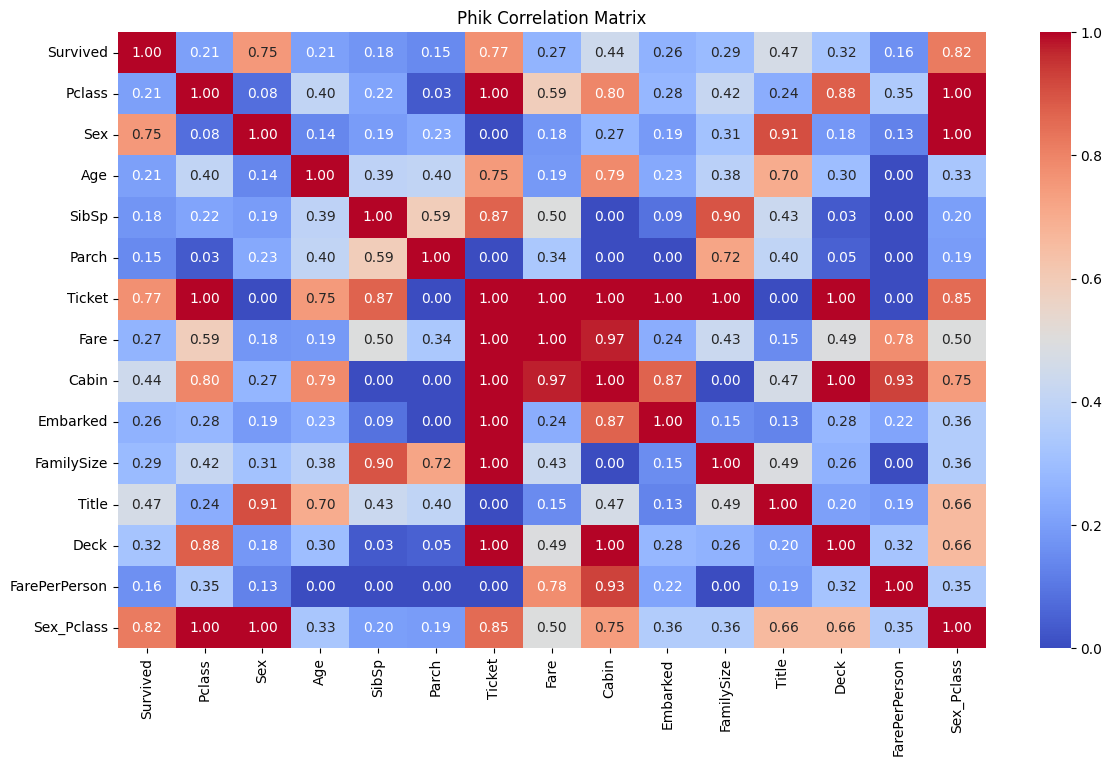

In [461]:
phik_matrix = train.drop(columns=['PassengerId']).phik_matrix(interval_cols=['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson'])

plt.figure(figsize=(14,8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik Correlation Matrix")
plt.show()      

In [462]:
train = train.drop(columns=['PassengerId', 'Ticket', 'Sex', 'Cabin', 'SibSp', 'Pclass'])
test = test.drop(columns=['Ticket', 'Sex', 'Cabin', 'SibSp', 'Pclass'])

In [463]:
# Выбираем корреляцию каждого признака с целевой переменной
target_correlations = phik_matrix['Survived']

# Сортируем по убыванию (по абсолютному значению)
target_correlations = target_correlations.abs().sort_values(ascending=False)

# Выводим результат
print("Корреляция признаков с целевой переменной 'Survived':")
print(target_correlations)

Корреляция признаков с целевой переменной 'Survived':
Survived         1.000000
Sex_Pclass       0.820091
Ticket           0.773153
Sex              0.750322
Title            0.465708
Cabin            0.444105
Deck             0.321486
FamilySize       0.287103
Fare             0.265387
Embarked         0.260620
Age              0.206987
Pclass           0.205464
SibSp            0.175652
FarePerPerson    0.162734
Parch            0.147080
Name: Survived, dtype: float64


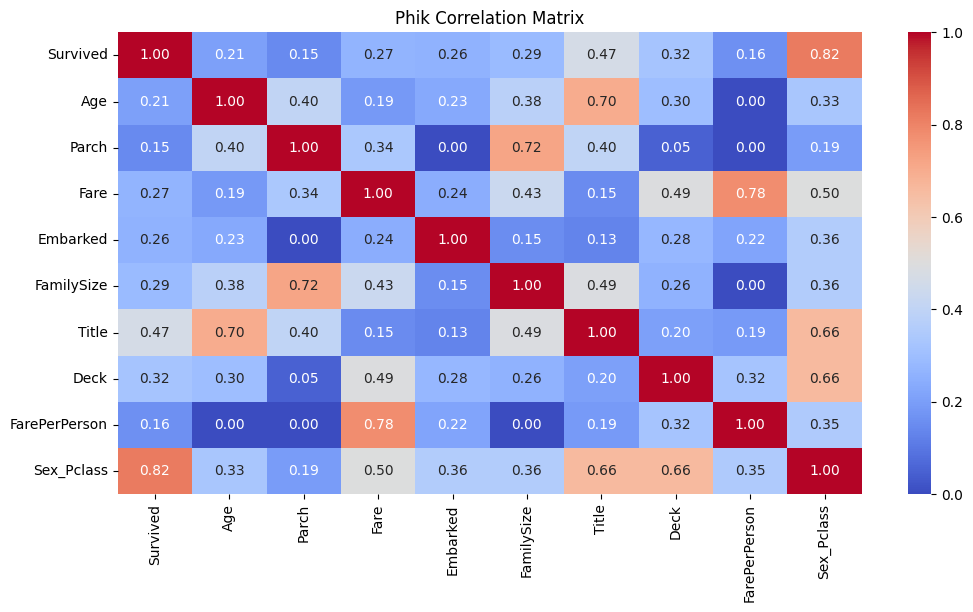

In [464]:
phik_matrix = train.phik_matrix(interval_cols=['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson'])
plt.figure(figsize=(12,6))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik Correlation Matrix")
plt.show()      

### Подготовка данных

#### Разбивка на трейн/тест

In [465]:
# 1. Подготовка данных
X = train.drop(columns=['Survived'])
y = train['Survived']


# # # Разделение с учетом дисбаланса
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, 
#     stratify=y, 
#     test_size=0.2, 
#     random_state=42
# )


# print('Размерность выборки X_train: ', X_train.shape)
# print('Размерность выборки X_val: ', X_val.shape)
# print('Размерность выборки y_train: ', y_train.shape)
# print('Размерность выборки y_val: ', y_val.shape)
# display(X_train.head())
# X_val.head()


### Обучение модели

In [466]:
%%time

cat_features = train.select_dtypes(include=['object']).columns.tolist()

# Создаем study с нужным sampler
study = optuna.create_study(
    direction='maximize',  # Так как мы максимизируем accuracy
    sampler=optuna.samplers.TPESampler(seed=42)
)

param_distributions = {
    'learning_rate': FloatDistribution(0.001, 0.1, log=True),  # Расширенный диапазон
    'depth': IntDistribution(4, 10),  # Оптимальный диапазон для Titanic
    'l2_leaf_reg': FloatDistribution(1e-3, 10.0, log=True),
    'min_data_in_leaf': IntDistribution(1, 20),
    'grow_policy': CategoricalDistribution(['SymmetricTree', 'Depthwise']),  # Добавлено
    'border_count': IntDistribution(32, 255),  # Важно для категориальных признаков
    'random_strength': FloatDistribution(1e-9, 10.0, log=True),  # Добавлено
    'subsample': FloatDistribution(0.5, 1.0),
    'colsample_bylevel': FloatDistribution(0.1, 1.0)
}

cat_model = CatBoostClassifier(
    random_seed=42,
    verbose=False,
    task_type='CPU',
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    loss_function='Logloss',
    cat_features=cat_features
)

cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,  # Включаем перемешивание
    random_state=42  # Фиксируем seed для воспроизводимости
)
oscv = OptunaSearchCV(
    estimator=cat_model, 
    param_distributions=param_distributions,
    cv=cv,
    scoring='accuracy',
    n_trials=5,
    n_jobs=-1,
    verbose=100,
    study=study
    
)

oscv.fit(X, y)

print("\nBest parameters:", oscv.best_params_)
print("Best CV score: {:.4f}".format(oscv.best_score_))

best_model = oscv.best_estimator_


[I 2025-06-09 20:15:31,614] A new study created in memory with name: no-name-57617877-7e49-4710-911a-7ed7661ae7a4
<timed exec>:36: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2025-06-09 20:16:28,340] Trial 1 finished with value: 0.83270911360799 and parameters: {'learning_rate': 0.01748687712715297, 'depth': 4, 'l2_leaf_reg': 0.26659744917508776, 'min_data_in_leaf': 19, 'grow_policy': 'Depthwise', 'border_count': 178, 'random_strength': 0.0004643091054594557, 'subsample': 0.632050497215841, 'colsample_bylevel': 0.2845157871717121}. Best is trial 1 with value: 0.83270911360799.
[I 2025-06-09 20:17:14,881] Trial 3 finished with value: 0.8293383270911361 and parameters: {'learning_rate': 0.029775766220508298, 'depth': 4, 'l2_leaf_reg': 0.004588001363282153, 'min_data_in_leaf': 14, 'grow_policy': 'SymmetricTree', 'border_count': 197, 'random_strength': 1.747734735987607e-08, 'subsample': 0.7725331780384577, 'col


Best parameters: {'learning_rate': 0.029847005140926117, 'depth': 6, 'l2_leaf_reg': 1.7878603755537772, 'min_data_in_leaf': 7, 'grow_policy': 'SymmetricTree', 'border_count': 199, 'random_strength': 4.2748108592568535e-08, 'subsample': 0.8653102148397236, 'colsample_bylevel': 0.3488590825012108}
Best CV score: 0.8372
CPU times: total: 14min 55s
Wall time: 2min 36s


In [478]:
# Создаем subplots
# Визуализация истории оптимизации
fig = visualization.plot_optimization_history(oscv.study_)
fig.update_layout(title_text="Визуализация истории оптимизации")
fig.show()

# Визуализация важности параметров
fig = visualization.plot_param_importances(oscv.study_)
fig.update_layout(title_text="Визуализация важности параметров")
fig.show()

# Контурные графики взаимодействий параметров
fig = visualization.plot_contour(oscv.study_, params=['learning_rate', 'depth'])
fig.update_layout(title_text="Контурные графики взаимодействий параметров")
fig.show()

In [479]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Age,17.412125
1,Sex_Pclass,15.893300
2,FarePerPerson,14.169463
3,Title,14.025524
4,Fare,13.259205
5,Embarked,11.209295
6,Deck,7.961188
7,FamilySize,5.294136
8,Parch,0.775764


In [487]:
best_model.fit(X, y)
y_pred = best_model.predict(X)
print(accuracy_score(y, y_pred))

0.9180695847362514


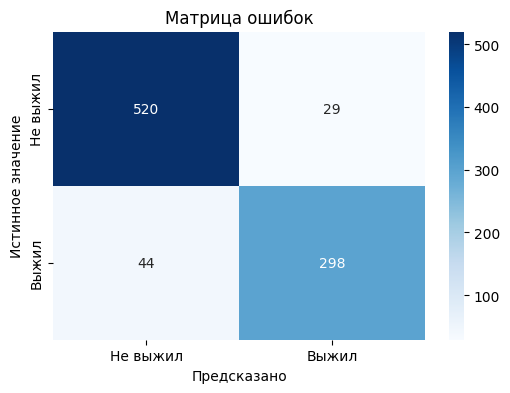

True Negative (TN): 520
False Positive (FP): 29
False Negative (FN): 44
True Positive (TP): 298


In [488]:
# Получаем матрицу ошибок
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Не выжил', 'Выжил'], yticklabels=['Не выжил', 'Выжил'])
plt.xlabel('Предсказано')
plt.ylabel('Истинное значение')
plt.title('Матрица ошибок')
plt.show()

print(f"True Negative (TN): {cm[0, 0]}")
print(f"False Positive (FP): {cm[0, 1]}")
print(f"False Negative (FN): {cm[1, 0]}")
print(f"True Positive (TP): {cm[1, 1]}")

#### Предсказание на тестовых данных

In [494]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

lr = LogisticRegression(random_state=42)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_features)
])
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lr', lr)
])

pipe.fit(X, y)









Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Parch', 'Fare',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Embarked', 'Title', 'Deck',
                                                   'Sex_Pclass'])])),
                ('lr', LogisticRegression(random_state=42))])

In [496]:
y_pred_test = pipe.predict(test[X.columns])

# 3. Создание файла для отправки
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_pred_test
})
submission.to_csv('data/submission.csv', index=False)